# **BMI Prediction From Human Photograph**
---




In [ ]:
!git clone https://github.com/atoms18/BMI-prediction-from-Human-Photograph.git

Cloning into 'BMI-prediction-from-Human-Photograph'...
remote: Enumerating objects: 4438, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 4438 (delta 16), reused 25 (delta 5), pack-reused 4396
Receiving objects: 100% (4438/4438), 342.69 MiB | 20.36 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (4232/4232), done.


In [ ]:
!pip install ninja
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd /content/Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs
%cd /content


Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (719/719), done.
remote: Compressing objects: 100% (568/568), done.
remote: Total 719 (delta 149), reused 610 (delta 140), pack-reused 0
Receiving objects: 100% (719/719), 3.88 MiB | 25.79 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/Self-Correction-Human-Parsing
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘inputs’: File exists
mkdir: cannot create directory ‘outputs’: File exists
/content


In [ ]:
!pip install livelossplot

In [ ]:

import cv2
import time
import gdown
import numpy
import pandas

from pathlib import Path
from keras import backend as K
from livelossplot import PlotLossesKeras
from sklearn.model_selection import KFold

import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

input_shape = (224, 224, 3)

## 1.Gathering Data

Datasets contains total of 2,272 images but consider as outlier 444 images so there is 1,828 images available for training and testing.

Sources:
*   Half of the data collectd from *The Photographic Height-Weight Chart* (www.height-weight-chart.com/heightweight.html) via python script.
*   Other half is celebrity body image download via python sctipt by recognites celebrity's name from their face which get from a paper "*Show me your face and I will tell you your height, weight and body mass index*" (https://hal.inria.fr/hal-01799574/document) and use their name to download their body image from Google Images.
*   A small data from *Face-to-height-weight-BMI-estimation* by abhaymise. (https://github.com/abhaymise/Face-to-height-weight-BMI-estimation-)

A data we have got is measured in Imperial system so we use:
\begin{equation}
BMI = \frac{Pound * 703}{(Foot * 12 + Inch)^2}
\end{equation}
To produce a BMI of each images.

/content/BMI-prediction-from-Human-Photograph
Total of datasets: 2272
Mean of BMI: 26.58938050842102
standard Deviation of BMI: 6.666706916267456


<ipython-input-20-541d34fcc185>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = hwcd_df.append(celeb_df, ignore_index=True)


,image_filename,weight,foot,inch,bmi
0,410-090-0.png,90,4,10,18.807967
1,410-090-1.png,90,4,10,18.807967
2,410-090-2.png,90,4,10,18.807967
3,410-090-3.png,90,4,10,18.807967
4,410-090-4.png,90,4,10,18.807967
...,...,...,...,...,...
2267,colinfarrell1.jpg,176,5,10,25.250612
2268,colinfarrell2.jpg,176,5,10,25.250612
2269,colinfarrell3.jpg,176,5,10,25.250612
2270,colinfarrell4.jpg,176,5,10,25.250612


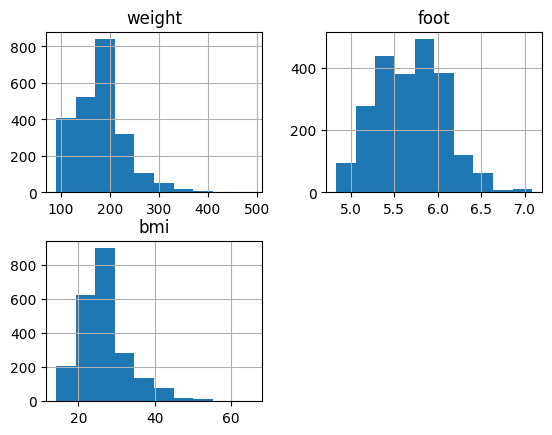

In [ ]:


%cd /content/BMI-prediction-from-Human-Photograph

hwcd_df = pandas.read_csv("height-weight-chart_dataset.csv")
celeb_df = pandas.read_csv("celeb_datasets.csv")

df = hwcd_df.append(celeb_df, ignore_index=True)
bmi = df["weight"] * 703 / (df["foot"] * 12 + df["inch"]) ** 2

foot = df["foot"] + df["inch"] / 12
df_display = df.drop(columns=["foot", "inch"])
df_display = df_display.assign(foot=foot, bmi=bmi)
df_display.hist()
print(f"Total of datasets: {len(bmi.index)}")
print(f"Mean of BMI: {bmi.mean()}")
print(f"standard Deviation of BMI: {bmi.std()}")

df.assign(bmi=bmi)



## 2.Preparing the data

We are preparing the data by using *Self Correction for Human Parsing* (https://github.com/PeikeLi/Self-Correction-Human-Parsing) by only extract a human body from raw dataset which the result of this model has shown below.
<table>
  <tr>
    <td>
      Original Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=11oqtX5cPf5xCU2IvYBLVFs5sqnMlfm5T" width="200">
    </td>
    <td>
      Preprocessed Image using a model:<br>
      <img src="https://drive.google.com/uc?export=view&id=1ydyIAvFcoIlAxyUago_ZkJuyfSXjEooC" width="200">
    </td>
  </tr>
</table>

And we use a preprocessed image as a filter to get rid of the background by convert all of its colors pixel to 1 and multiply them to original image.

<table>
  <tr>
    <td>
      Filter Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=18rjY14s3a_i9tYWXGR-FOLu0PJ2LpkvG" width="200">
    </td>
    <td>
      Labeled Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=1Bqf6gtkBdL8xhsP8hEXcMDeHMVyiu_k4" width="200" height="273">
    </td>
  </tr>
</table>

Then we resize a labeled image to 244 x 244 x 3 to suit the Resnet152 recommend input tensor.


In [ ]:


# def rgb2gray(rgb):
#     return numpy.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def preprocess_df(x, y):
  x = x.reset_index()
  X = []
  Y = []
  for i in range(x.shape[0]):

    image_filename = Path(x['image_filename'][i]).stem

    raw_filepath = 'raw_datasets/' + image_filename + ".jpg"
    preprocessed_filepath = 'raw_datasets_preprocessed/' + image_filename + ".png"
    if not Path(raw_filepath).is_file():
      raw_filepath = 'celeb_datasets/' + image_filename + ".jpg"
      preprocessed_filepath = 'celeb_datasets_preprocessed/' + image_filename + ".png"

    if Path(raw_filepath).is_file() and Path(preprocessed_filepath).is_file():
      raw_img = image.load_img(raw_filepath, target_size=(600, 400))
      raw_img = image.img_to_array(raw_img)
      preprocessed_img = image.load_img(preprocessed_filepath, target_size=(600, 400))
      preprocessed_img = image.img_to_array(preprocessed_img)

      preprocessed_img[preprocessed_img[:,:,0] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,1] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,2] > 0] = 1
      # img[numpy.all(img == (128, 128, 128), axis=-1)] = (0, 0, 128) # replace gray with blue
      # img[numpy.all(img == (0, 64, 0), axis=-1)] = (0, 0, 0) # replace green with black
      # img[numpy.all(img == (128, 0, 128), axis=-1)] = (0, 128, 128) # replace purple with cyan
      # img = rgb2gray(img).reshape(input_shape)

      # plt.imshow((raw_img * preprocessed_img).astype(int))
      # break

      X.append(cv2.resize(raw_img * preprocessed_img, (input_shape[0], input_shape[1])))
      Y.append(y.iloc[i])

  X = numpy.array(X)
  Y = numpy.array(Y)
  return [X, Y]

start = time.clock()
X, Y = preprocess_df(df, bmi)
end = time.clock()
print(f"{end - start:.2f} seconds process time")


AttributeError: ignored

### Data Normalization and Augmentation

We use ImageDataGenerator to normalize a labeled and to be augmented by rotating, shifting and horizontal flipling.

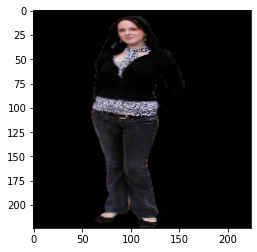

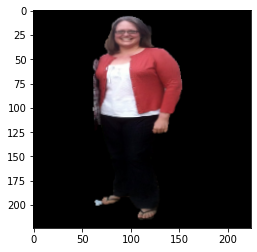

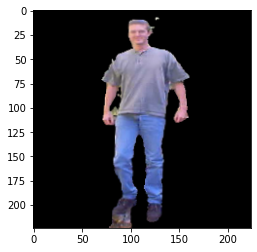

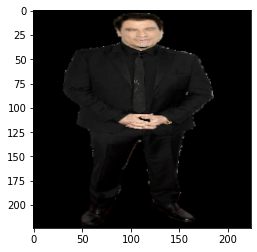

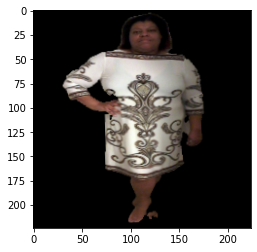

In [ ]:

train_datagen = image.ImageDataGenerator(
  samplewise_center=True,
  rotation_range=2,
  width_shift_range=0.02,
  # height_shift_range=0.02,
  # shear_range=0.02,
  # zoom_range=0.02,
  horizontal_flip=True
)
j = 0
for batch in train_datagen.flow(X, batch_size=5):
  for b in batch:
    plt.figure(j)
    plt.imshow(image.array_to_img(b))
    j += 1
  break

test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

## 3.Choosing a model

* From the experiments, we decide to use ResNet152 for the best results.
* We use pre-trained weight called "imagenet" to initialize a model.
* By using it, we mean that we use it for extract a feature of human from an image so we freeze an entire model and feed an output to Fully-Connected Layer.
* A Fully-Connected Layer contains 256 neurons and using ReLu function as activation function.
* We use dropout layer with probability 0.25
* An output layer consist of only one neuron which uses linear activation function.


<img src="https://drive.google.com/uc?export=view&id=1u20brFPULhqItLZCa1zrmiHkaNKtqvMX" width="450">

In [ ]:
base_model = keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg"
)

base_model.trainable = False
base_model.summary()

234698864/234698864 [==============================] - 5s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                   

### Extract Features

* We use k-fold cross validation to train a model by we choose k=5 and in the meanwhile, we do a features extraction before initialize our own model.
* We keep all 5 fold in the list called train_features, train_labels, test_features and test_labels for not to repeated it.

In [ ]:
batch_size=32
def extract_features(x, y, sample_count, datagen):
    features = numpy.zeros(shape=(sample_count, 2048))
    labels = numpy.zeros(shape=(sample_count))
    generator = datagen.flow(
        x, y,
        batch_size=batch_size
    )
    total = 0
    left_index = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        gap = features_batch.shape[0]
        total += gap
        gap_diff = total - sample_count
        gap_diff = gap_diff if gap_diff > 0 else 0
        features[left_index : left_index + (gap-gap_diff)] = features_batch[0:gap-gap_diff]
        labels[left_index : left_index + (gap-gap_diff)] = labels_batch[0:gap-gap_diff]
        left_index += gap
        if total >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features = [None]*5
train_labels = [None]*5
test_features = [None]*5
test_labels = [None]*5

k = 0
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
  X_train, Y_train, X_test, Y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]

  print(f"Extract features from fold number {k+1}")
  start = time.clock()
  train_features[k], train_labels[k] = extract_features(X_train, Y_train, 2000, datagen=train_datagen)
  test_features[k], test_labels[k] = extract_features(X_test, Y_test, 2000, datagen=test_datagen)
  end = time.clock()
  print(f"Finished with {end - start:.2f} seconds process time")
  k += 1

NameError: ignored

## 4.Training
* Optimizer: The stochastic gradient descent (SGD) algorithm.
* Learning Rate: Start from 1e-5 and then we use the learning rate decay policy, which is implemented as follows:
\begin{equation}
LR = LR_{Base} (1 + \gamma * epoch)^{-power}
\end{equation}
where γ is 0.001 and power is 0.75. We use a momentum of 0.9
* Loss function: Huber function
* Metrics: Huber, Mean Absolute Error and R Squared

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lr_scheduler(epoch, lr):
   return 1e-5 * (1 + 0.001 * epoch) ** (-0.75)

In [ ]:




VALIDAITON_LOSS = []

for j in range(5):
  model = Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim=2048))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(1, activation='linear'))

  model.compile(optimizer=keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum=0.9
  ), loss=keras.losses.Huber(), metrics=["mean_absolute_error", coeff_determination])

  history = model.fit(train_features[j], train_labels[j], epochs=500,
    validation_data=(test_features[j], test_labels[j]),
    verbose=2,
    callbacks=[
          PlotLossesKeras(),
          keras.callbacks.LearningRateScheduler(lr_scheduler),
    ]
  )
  model.save(f"last_model{j}.h5")

  results = model.evaluate(test_features[j], test_labels[j])
  VALIDAITON_LOSS.append(results)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([0, 25])
# plt.show()

# history = model.fit(train_datagen.flow(x_train, y_train, batch_size=16),
#                     epochs=1000,
#                     validation_data=test_datagen.flow(x_test, y_test, batch_size=32),
#                     verbose=2,
#                     callbacks=[
#                           PlotLossesKeras(),
#                           keras.callbacks.LearningRateScheduler(lr_scheduler),
#                           # keras.callbacks.EarlyStopping(
#                           #     monitor='val_loss',
#                           #     patience=5,
#                           #     restore_best_weights=True
#                           # )
#                     ]
# )



ValueError: ignored

## 5.Evaluvate

[Huber loss, MAE, R Squared] of all 5-folds

In [ ]:
VALIDAITON_LOSS


[[3.7254703044891357, 4.192523956298828, 0.2898770868778229],
 [3.853140115737915, 4.323094844818115, 0.3603218197822571],
 [3.4870858192443848, 3.9460318088531494, 0.3224889934062958],
 [3.5555806159973145, 4.03022575378418, 0.2583730220794678],
 [4.191390514373779, 4.6717939376831055, 0.23626717925071716]]

## 6.Test with your photo!

We have selected the best model which MAE is equal to 4.053

In [ ]:

%cd /content/Self-Correction-Human-Parsing
atr_dataset_url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
gdown.download(atr_dataset_url, 'checkpoints/atr.pth', quiet=False)

/content/Self-Correction-Human-Parsing


Downloading...
From: https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP
To: /content/Self-Correction-Human-Parsing/checkpoints/atr.pth
100%|██████████| 267M/267M [00:03<00:00, 77.3MB/s]


'checkpoints/atr.pth'

In [ ]:
import cv2
import numpy as np

def resizeAndPad(img, size, padColor=0):
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw:  # shrinking image
        interp = cv2.INTER_AREA
    else:  # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w / h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1:  # horizontal image
        new_w = sw
        new_h = np.round(new_w / aspect).astype(int)
        pad_vert = (sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1:  # vertical image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = (sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else:  # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor,
                                              (list, tuple, np.ndarray)):  # color image but only one color provided
        padColor = [padColor] * 3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT,
                                    value=padColor)
    # print(h_img.shape[:2])
    return scaled_img

In [ ]:
%cd /content/Self-Correction-Human-Parsing/inputs
from google.colab import files
uploaded = files.upload()

/content/Self-Correction-Human-Parsing/inputs


In [ ]:
print(uploaded)

{'peo.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00\xc7Exif\x00\x00II*\x00\x08\x00\x00\x00\x04\x00\x0e\x01\x02\x00_\x00\x00\x00>\x00\x00\x00\x98\x82\x02\x00\x12\x00\x00\x00\x9d\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00\xaf\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00\xb7\x00\x00\x00\x00\x00\x00\x00Overweight or Fat Shirtless Man Proudly Showing his Large Belly and smiling. Isolated on White.AleksandarGeorgiev,\x01\x00\x00\x01\x00\x00\x00,\x01\x00\x00\x01\x00\x00\x00\xff\xe1\x05\x9ahttp://ns.adobe.com/xap/1.0/\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?>\n<x:xmpmeta xmlns:x="adobe:ns:meta/">\n\t<rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">\n\t\t<rdf:Description rdf:about="" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" xmlns:Iptc4xmpCore="http://iptc.org/std/Iptc4xmpCore/1.0/xmlns/"   xmlns:GettyImagesGIFT="http://xmp.gettyimages.com/gift/1.0/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:plus="ht

In [ ]:
import os
from PIL import Image

%cd /content/Self-Correction-Human-Parsing

input_filename = Path(next(iter(uploaded))).stem
reshape_image = cv2.imread("inputs/" +  next(iter(uploaded)))
x1, x2 = reshape_image.shape[:2]
print("Raw shape: " + str(reshape_image.shape[:2]))
big = max(x1, x2)
reshape_image = resizeAndPad(reshape_image, (big, big), 255)
path_input = "inputs/" +  next(iter(uploaded))
cv2.imwrite(path_input, reshape_image)
print("Raw shape2: " + str(reshape_image.shape[:2]))

/content/Self-Correction-Human-Parsing
Raw shape: (534, 194)
Raw shape2: (534, 534)


In [ ]:
input_filename = Path(next(iter(uploaded))).stem
test_shape = cv2.imread("inputs/" +  next(iter(uploaded)))
print(next(iter(uploaded)))
print("Raw shape: " + str(test_shape.shape[:2]))

5.png
Raw shape: (534, 534)


/content/Self-Correction-Human-Parsing
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Traceback (most recent call last):
  File "/content/Self-Correction-Human-Parsing/simple_extractor.py", line 24, in <module>
    import networks
  File "/content/Self-Correction-Human-Parsing/networks/__init__.py", line 3, in <module>
    from networks.AugmentCE2P import resnet101
  File "/content/Self-Correction-Human-Parsing/networks/AugmentCE2P.py", line 21, in <module>
    from modules import InPlaceABNSync
  File "/content/Self-Correction-Human-Parsing/modules/__init__.py", line 1, in <module>
    from .bn import ABN, InPlaceABN, InPlaceABNSync
  File "/content/Self-Correction-Human-Parsing/modules/bn.py", line 10, in <module>
    from .functions import *
  File "/content/Self-Correction-Human-Parsing/modules/functions.py", line 10, in <module>
    _backend = load(name="inplace_abn",
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py", line 1308, in load
   

FileNotFoundError: ignored

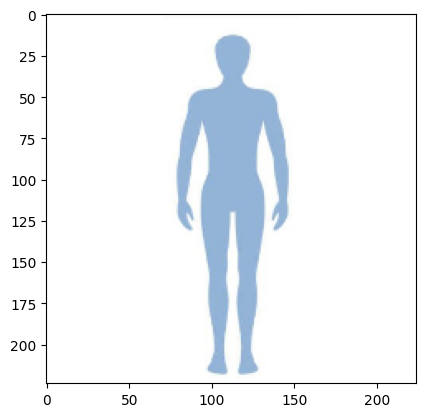

In [ ]:
%cd /content/Self-Correction-Human-Parsing
!python3 simple_extractor.py --dataset 'atr' --model-restore 'checkpoints/atr.pth' --input-dir 'inputs' --output-dir 'outputs'

input_filename = Path(next(iter(uploaded))).stem

raw_input_image = cv2.imread("inputs/" +  next(iter(uploaded)))
raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)
print("Raw shape: " + str(raw_input_image.shape[:2]))
raw_input_image = cv2.resize(raw_input_image, (input_shape[0], input_shape[1]))
print("Raw shape 2: " + str(raw_input_image.shape[:2]))
plt.figure(0)
plt.imshow(raw_input_image)

preprocessed_input_image = image.load_img("outputs/" +  input_filename + ".png", target_size=input_shape)
preprocessed_input_image = image.img_to_array(preprocessed_input_image)
plt.figure(1)
plt.imshow(preprocessed_input_image.astype(int))

plt.figure(2)
preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1
plt.imshow(preprocessed_input_image)

plt.figure(3)
final_input_image = raw_input_image * preprocessed_input_image
plt.imshow(final_input_image.astype(int))


In [ ]:

test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

generator = test_datagen.flow(
    numpy.expand_dims(final_input_image, axis=0),
    batch_size=1
)
features_batch = base_model.predict(generator)

dependencies = {
    'coeff_determination': coeff_determination
}
model = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/3.935_model.h5', custom_objects=dependencies)
preds = model.predict(features_batch)
bmi_pred = preds[0][0]
print(f"BMI: {bmi_pred}")
model2 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.053_model.h5', custom_objects=dependencies)
preds2 = model2.predict(features_batch)
bmi_pred = preds2[0][0]
print(f"BMI: {bmi_pred}")
model3 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.087_model.h5', custom_objects=dependencies)
preds3 = model3.predict(features_batch)
bmi_pred = preds3[0][0]
print(f"BMI: {bmi_pred}")
model4 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.129_model.h5', custom_objects=dependencies)
preds4 = model4.predict(features_batch)
bmi_pred = preds4[0][0]
print(f"BMI: {bmi_pred}")
model5 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.170_model.h5', custom_objects=dependencies)
preds5 = model5.predict(features_batch)
bmi_pred = preds5[0][0]
print(f"BMI: {bmi_pred}")
model6 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.396_model.h5', custom_objects=dependencies)
preds6 = model6.predict(features_batch)
bmi_pred = preds6[0][0]
print(f"BMI: {bmi_pred}")
model7 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.471_model.h5', custom_objects=dependencies)
preds7 = model7.predict(features_batch)
bmi_pred = preds7[0][0]
print(f"BMI: {bmi_pred}")

if bmi_pred < 15:
  print("Very severely underweight")
elif 15 <= bmi_pred < 16:
  print("Severely underweight")
elif 16 <= bmi_pred < 18.5:
  print("Underweight")
elif 18.5 <= bmi_pred < 25:
  print("Normal")
elif 25 <= bmi_pred < 30:
  print("Overweight")
elif 30 <= bmi_pred < 35:
  print("Moderately obese")
elif 35 <= bmi_pred < 40:
  print("Severely obese")
elif bmi_pred >= 40:
  print("Very severely obese")



**References**
<p>- Self-Correction for Human Parsing (https://arxiv.org/pdf/1910.09777.pdf)</p>
<p>- Show me your face and I will tell you your height,
weight and body mass index (https://hal.inria.fr/hal-01799574/document)</p>
<p>- Estimation of Body Mass Index from
Photographs using Deep Convolutional Neural
Networks (https://arxiv.org/pdf/1908.11694v1.pdf)</p>
